In [86]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import yaml

from model.model import get_model
from data_loader import TrainDataModule, get_all_test_dataloaders, get_normal_test_dataloader

# autoreload imported modules
%load_ext autoreload
%autoreload 2
%matplotlib inline


# with open("./configs/ganomaly_config.yaml", "r") as f:
with open("./configs/ganomaly_config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Reproducibility
pl.seed_everything(config["seed"])

test_dataloaders = get_all_test_dataloaders(config['split_dir'], config['target_size'], config['batch_size'])

Global seed set to 42


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
img_csv='./data/splits/absent_septum.csv' 
 len(self.img_paths)=1
img_csv='./data/splits/artefacts.csv' 
 len(self.img_paths)=16
img_csv='./data/splits/craniatomy.csv' 
 len(self.img_paths)=15
img_csv='./data/splits/dural.csv' 
 len(self.img_paths)=7
img_csv='./data/splits/ea_mass.csv' 
 len(self.img_paths)=4
img_csv='./data/splits/edema.csv' 
 len(self.img_paths)=18
img_csv='./data/splits/encephalomalacia.csv' 
 len(self.img_paths)=1
img_csv='./data/splits/enlarged_ventricles.csv' 
 len(self.img_paths)=19
img_csv='./data/splits/intraventricular.csv' 
 len(self.img_paths)=1
img_csv='./data/splits/lesions.csv' 
 len(self.img_paths)=22
img_csv='./data/splits/mass.csv' 
 len(self.img_paths)=22
img_csv='./data/splits/posttreatment.csv' 
 len(self.img_paths)=44
img_csv='./data/splits/resection.csv' 
 len(self.img_paths)=10
img_csv='./data/splits/sinus.csv' 
 len(self.img_paths)=2
img_csv='./data/splits/w

In [87]:
# load model from checkpit
from model.ganomaly.lightning_model import Ganomaly


model = get_model(config)
# Specify the path to your checkpoint file
checkpoint_path = '/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_14/checkpoints/epoch=149-step=6900.ckpt'
# checkpoint_path = '/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_17/checkpoints/epoch=49-step=2300.ckpt'
# checkpoint_path = '/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_16/checkpoints/epoch=9-step=460.ckpt'
# Initialize the model by loading from the checkpoint
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])


Loading model ganomaly


<All keys matched successfully>

In [88]:
from ganomaly_eval import  GanomalyEvaluator, EvalType
normal_test_dataloader = get_normal_test_dataloader(config['split_dir'], config['target_size'], config['batch_size'])
normal_and_abnormal = test_dataloaders.copy()
normal_and_abnormal.update({"normal":normal_test_dataloader})


evaluator = GanomalyEvaluator(model, normal_and_abnormal)

evaluator.evaluate_model(normalize=True)

img_csv='./data/splits/normal_test.csv' 
 len(self.img_paths)=30


## Stats

In [89]:
# evaluator.normalize_scores()
evaluator.print_stats_table()

                    Statistics of Anomaly Scores per categroy                    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Pathology           ┃ Minimum ┃ Maximum ┃ Median ┃ Mean ┃ Variance ┃ #Samples ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ absent_septum       │    0.14 │    0.14 │   0.14 │ 0.14 │     0.00 │        1 │
│ artefacts           │    0.02 │    0.14 │   0.05 │ 0.05 │     0.00 │       16 │
│ craniatomy          │    0.01 │    0.64 │   0.09 │ 0.13 │     0.02 │       15 │
│ dural               │    0.01 │    0.27 │   0.14 │ 0.13 │     0.01 │        7 │
│ ea_mass             │    0.12 │    0.27 │   0.26 │ 0.23 │     0.00 │        4 │
│ edema               │    0.04 │    1.00 │   0.12 │ 0.17 │     0.04 │       18 │
│ encephalomalacia    │    0.62 │    0.62 │   0.62 │ 0.62 │     0.00 │        1 │
│ enlarged_ventricles │    0.03 │    0.60 │   0.09 │ 0.16 │     0.03 │       19 │
│ intraventricular    │    0.13 │    0.13 │   0.13 │ 0.13 │     0.00 │        1 │
│ lesions             │    0.03 │    0.28 │   0.07 │ 0.11 │     0.01 │       22 │
│ mass                │    0.05 │    0.28 │   0.11 │ 0.13 │     0.01 │       22 │
│ posttreatment       │    0.02 │    0.91 │   0.09 │ 0.11 │     0.02 │       44 │
│ resection           │    0.03 │    0.61 │   0.16 │ 0.23 │     0.04 │       10 │
│ sinus               │    0.04 │    0.20 │   0.12 │ 0.12 │     0.01 │        2 │
│ wml                 │    0.03 │    0.14 │   0.07 │ 0.08 │     0.00 │        5 │
│ other               │    0.07 │    0.25 │   0.12 │ 0.16 │     0.01 │        5 │
│ normal              │    0.00 │    0.60 │   0.05 │ 0.12 │     0.03 │       30 │
└─────────────────────┴─────────┴─────────┴────────┴──────┴──────────┴──────────┘

## Histograms

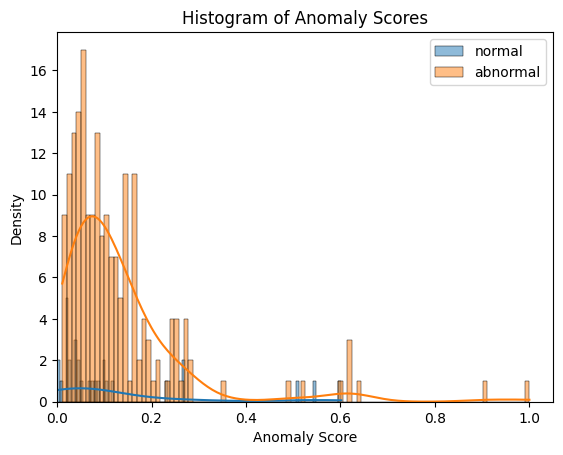

In [90]:
evaluator.histplot()

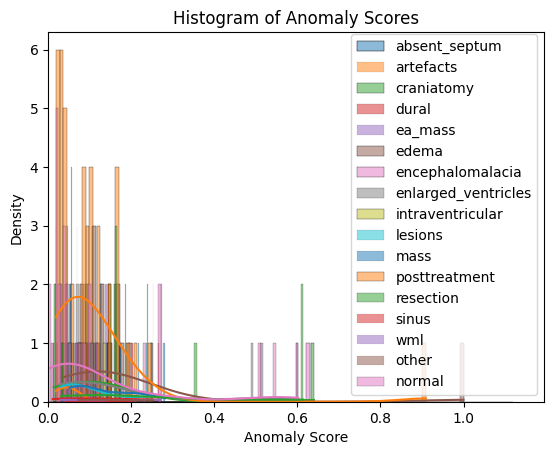

In [91]:
evaluator.histplot(eval_type=EvalType.ALL)

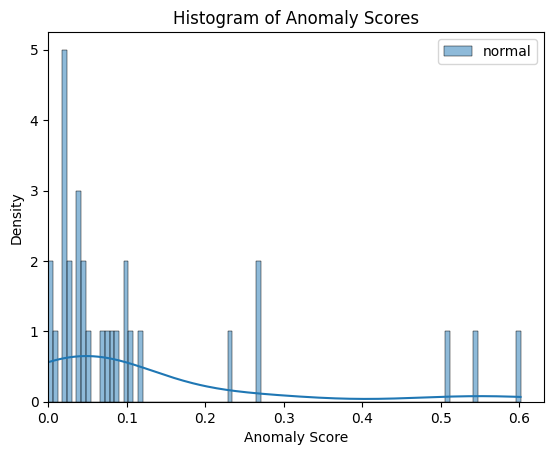

In [92]:
evaluator.histplot(EvalType.NORMAL)

# Metrics

## Find optimal threshold

In [93]:
optimal_threshold = evaluator.find_optimal_threshold_f1()
print(optimal_threshold)

0.011080828


## General classification report

In [94]:
evaluator.classification_report(threshold=optimal_threshold)

              precision    recall  f1-score   support

           0       0.67      0.07      0.12        30
           1       0.87      0.99      0.93       192

    accuracy                           0.87       222
   macro avg       0.77      0.53      0.53       222
weighted avg       0.84      0.87      0.82       222



## Confusion matrix

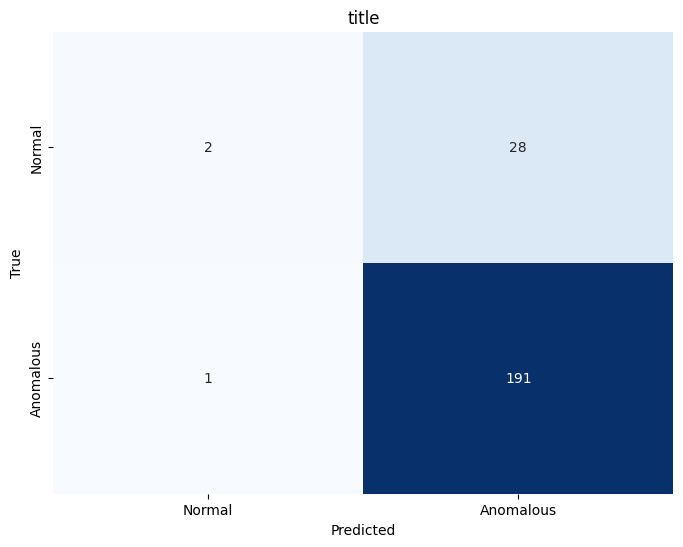

In [95]:
evaluator.plot_confusion_matrix(threshold=optimal_threshold)

## AUROC

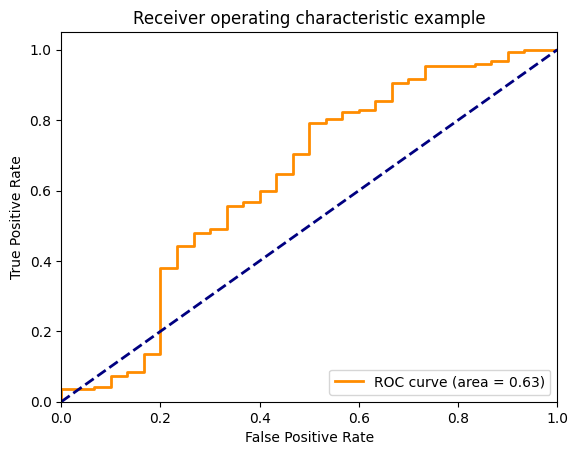

In [96]:
# evaluator.roc_auc_score()
evaluator.plot_auroc()

## PRC AUC

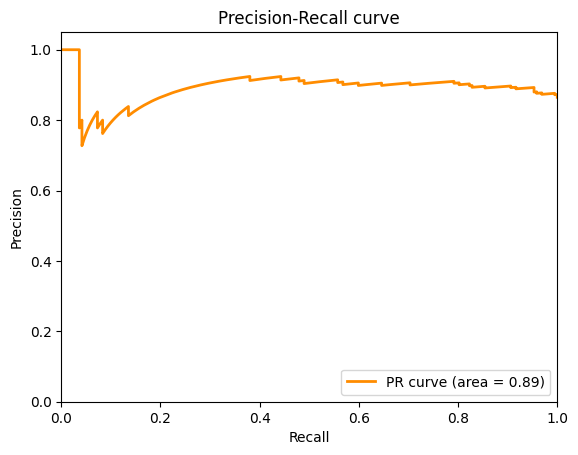

In [97]:
# evaluator.prc_auc_score()
evaluator.plot_auprc()

# Reconstructions

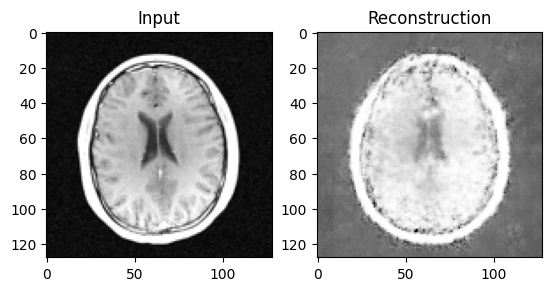

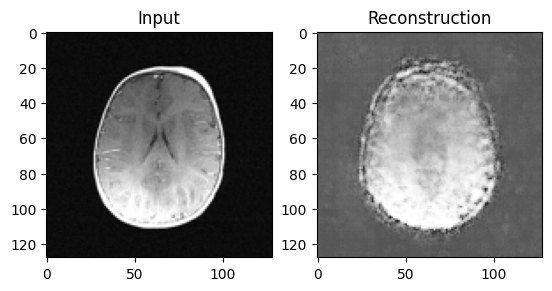

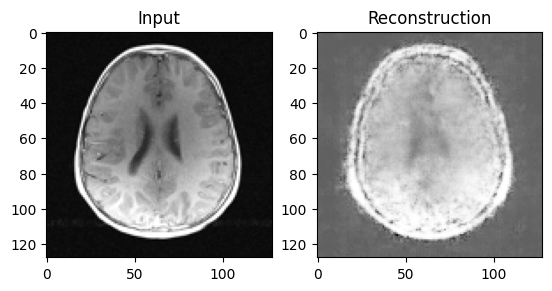

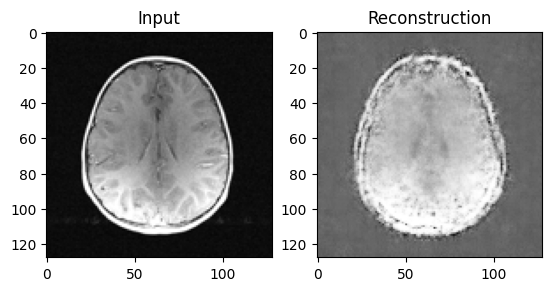

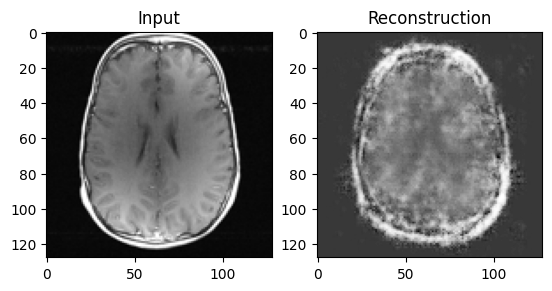

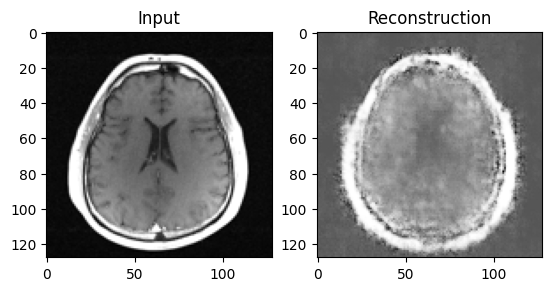

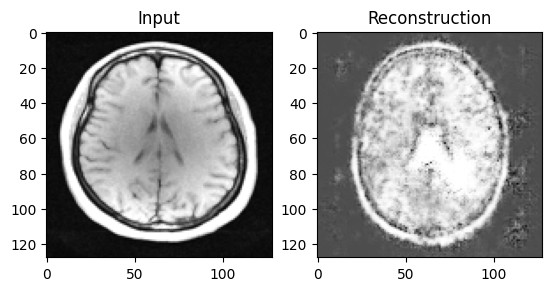

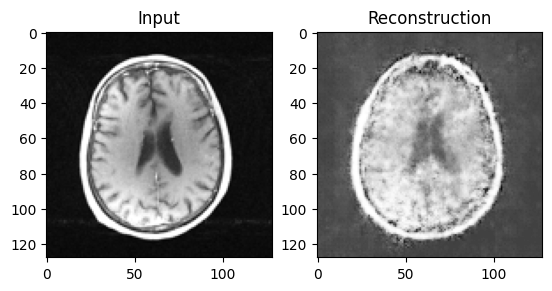

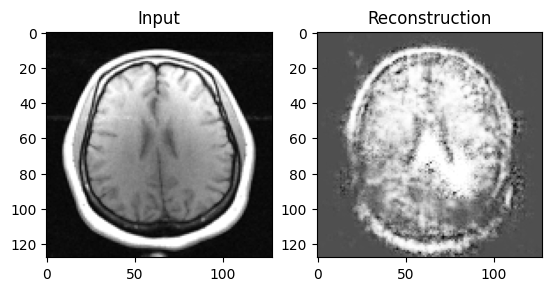

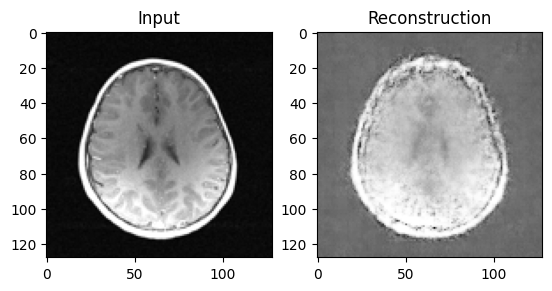

In [98]:
evaluator.plot_in_rec(label="normal", n=10)

In [99]:
# fig_metrics.keys()

In [100]:
# fig_metrics['F1']

In [101]:
# fig_example.savefig(f"example_{config['num_epochs']}.png")